# EYE FOR BLIND
This notebook was used to prepare the capstone project 'Eye for Blind'

#### <span style="color:Green">__Team Details:__</span> 

1. Aparna Vittala
2. Shrey Khurana
3. Yashodhara Gowda

For implementation details using Docker container and Streamlit, please check out the below git repository.
https://github.com/avittala03/upgrad_capstone.git

In [1]:
#Import all the required libraries

import numpy as np 
import pandas as pd




Let's read the dataset

**Eye For Blind**

**Problem Statement:**
Create a model which is able to caption an image to help blind people, so that they can also get the feel of image.

**Notebook Description:**
This notebook will contain code which are used to create audio text from an given image which very useful for blind people.

Attention model mechenism has been used with Encoder and Decorder mechenism.
**Greedy Search** and **Beam Search** has been used

**Encoder:** It will get create the features of the image</br>
**Decoder:** It use the features created by Encoder and output from attention model.</br>
**Attention Mechenism:** It is used to overcome the problem of Encoder and Decoder architecture. By using this we need to focus only the specific part of the image while generating caption (as human do i.e when we want to describe any paerticular object we only focus on that object as that time).

In [2]:
import gc
gc.collect()

23

In [4]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.6 MB/s eta 0:00:0000:010:01


In [10]:
# import libraries

import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split 

#model building 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import load_img, img_to_array
from keras.utils import pad_sequences
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from tqdm import tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [18]:
# Defining paths
INPUT_PATH = "./input/"
IMAGE_PATH = INPUT_PATH+'Images/'
CAPTIONS_FILE = INPUT_PATH+'captions.txt'
OUTPUT_IMAGE_PATH = "./working/Image/"

In [15]:
images="./input/Images"
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


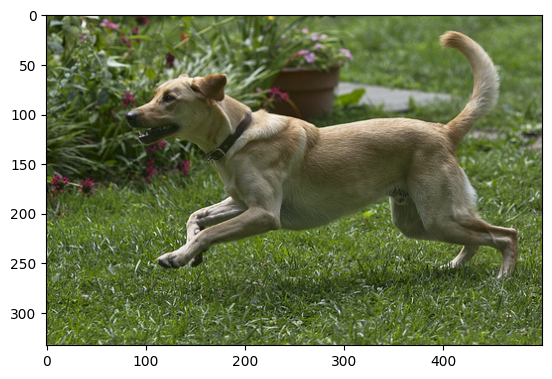

In [16]:
#Visualise both the images & text present in the dataset
plt.imshow(mpimg.imread(all_imgs[0]))


In [19]:
def load_doc(filename):
    
    with open(filename,'r') as f_in:
        text = list(filter(None, (line.rstrip() for line in f_in)))
    f_in.close()

    col=[]
    for line in text:
        col.append(line.split(",",maxsplit=1)) #Maxsplit 1 used to handle the captions with comma

    return col

doc = load_doc(CAPTIONS_FILE)
doc[:30]

[['image', 'caption'],
 ['1000268201_693b08cb0e.jpg',
  'A child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  'A little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'A little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'A little girl in a pink dress going into a wooden cabin .'],
 ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'],
 ['1001773457_577c3a7d70.jpg',
  'A black dog and a tri-colored dog playing with each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'A black dog and a white dog with brown spots are staring at each other in the street .'],
 ['1001773457_577c3a7d70.jpg',
  'Two dogs of different breeds looking at each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'Two dogs on pavement moving toward each other .'],
 ['1002674143_1b742ab4b8.

In [20]:
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io

pd.set_option('display.max_colwidth', -1)


def get_thumbnail(path):
    #path = "\\\\?\\"+path # This "\\\\?\\" is used to prevent problems with long Windows paths
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}" style="max-height:124px;">'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


In [21]:
all_img_id = []
all_img_vector = []
annotations = []
image_visual = []
# get image_id, image_caption and image_path


all_img_id = [i[0] for i in doc[1:]] #store all the image id here
all_img_vector= [IMAGE_PATH+i[0] for i in doc[1:]] #store all the image path here
annotations= [i[1] for i in doc[1:]] #store all the captions here
#image_visual = [get_thumbnail(IMAGE_PATH+i[0]) for i in doc[1:]] 
#


# Commenting as this 
#doc = doc.splitlines()[1:]
#for line in doc:
    #com_id =line.index(",")
    #img_id = line[:com_id]
    #all_img_id.append(img_id)

    #annotations.append(line[com_id +1:])
    #all_img_vector.append(IMAGE_PATH + "/" + img_id)
    #image_visual.append(get_thumbnail(IMAGE_PATH + "/" + img_id))
    
#    all_img_id.append(line[:line.index(",")])
#    annotations.append(line[line.index(",") +1:])
#    all_img_vector.append(IMAGE_PATH + "/" + line[:line.index(",")])
#    image_visual.append(get_thumbnail(IMAGE_PATH + "/" + line[:line.index(",")]))
    
df= pd.DataFrame(zip(all_img_id, all_img_vector, annotations), columns=['ID', 'Path', 'Captions'])
df.head()


ID                                      Path  \
0  1000268201_693b08cb0e.jpg  ./input/Images/1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg  ./input/Images/1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg  ./input/Images/1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg  ./input/Images/1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg  ./input/Images/1000268201_693b08cb0e.jpg   

                                                                   Captions  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1  A girl going into a wooden building .                                     
2  A little girl climbing into a wooden playhouse .                          
3  A little girl climbing the stairs to her playhouse .                      
4  A little girl in a pink dress going into a wooden cabin .

In [22]:
df_img = pd.DataFrame(zip([get_thumbnail(i) for i in df.Path.head().to_list()], df.Captions.head()), columns=['Images', 'Captions'])


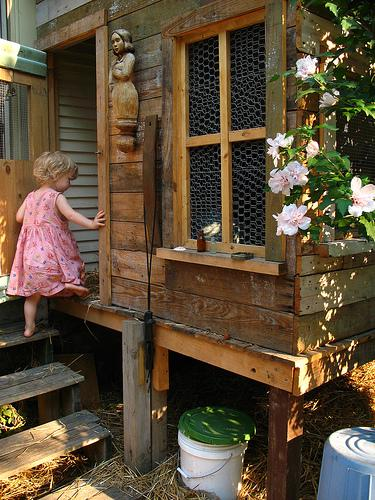
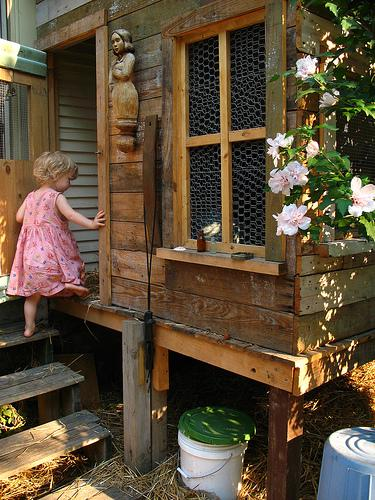
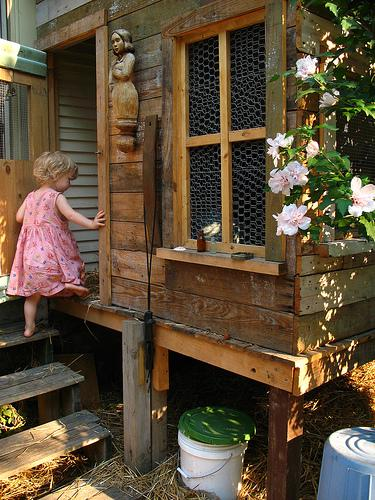
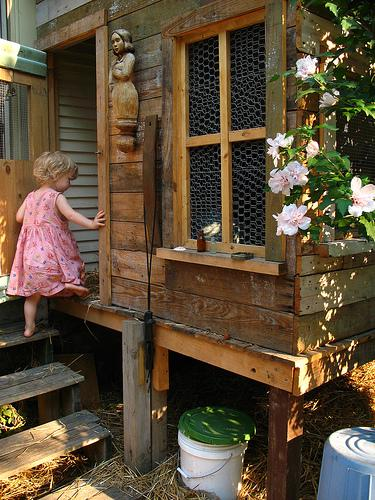
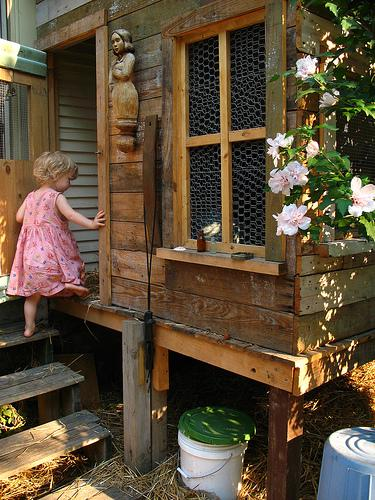

In [23]:
#Mapping of Image and Caption
HTML(df_img.to_html(formatters={'Images': image_formatter}, escape=False))

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [25]:
#Create a list which contains all the captions
annotations = []

#add the <start> & <end> token to all those captions as well
for cap in df.Captions:
    cap='<start> '+ cap + ' <end>'
    annotations.append(cap)


#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [26]:
uni_filenames= np.unique(df.ID.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:", Counter(Counter(df.ID.values).values()))

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


In [28]:
# get the vocabulary from the captions
vocabulary = []
for cap in df.Captions.values:
        vocabulary.extend(cap.split())
        
val_count = Counter(vocabulary)
print("Size of Vocab : ",len(set(vocabulary)))

Size of Vocab :  9862


In [29]:
val_count.most_common(30)

[('a', 40271),
 ('.', 34212),
 ('A', 21481),
 ('in', 18961),
 ('the', 15328),
 ('on', 10729),
 ('is', 9345),
 ('and', 8850),
 ('dog', 7982),
 ('with', 7760),
 ('man', 6828),
 ('of', 6712),
 ('Two', 3962),
 ('white', 3875),
 ('black', 3696),
 ('are', 3503),
 ('boy', 3442),
 ('woman', 3227),
 ('girl', 3217),
 (',', 3210),
 ('to', 3173),
 ('wearing', 3061),
 ('The', 2920),
 ('at', 2904),
 ('water', 2774),
 ('red', 2660),
 ('brown', 2475),
 ('people', 2442),
 ('young', 2431),
 ('."', 2365)]

In [30]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [31]:
sorted_list = val_count.most_common(30)

def plot_word_count(wordCountList):
    word_list,wc_list = [],[]
    for word, count in wordCountList:
        word_list.append(word)
        wc_list.append(count)
    plt.figure(figsize=(20,6))
    sns.barplot(x = word_list, y = wc_list, orient='v').set_title('Top 30 occurinng words')
        

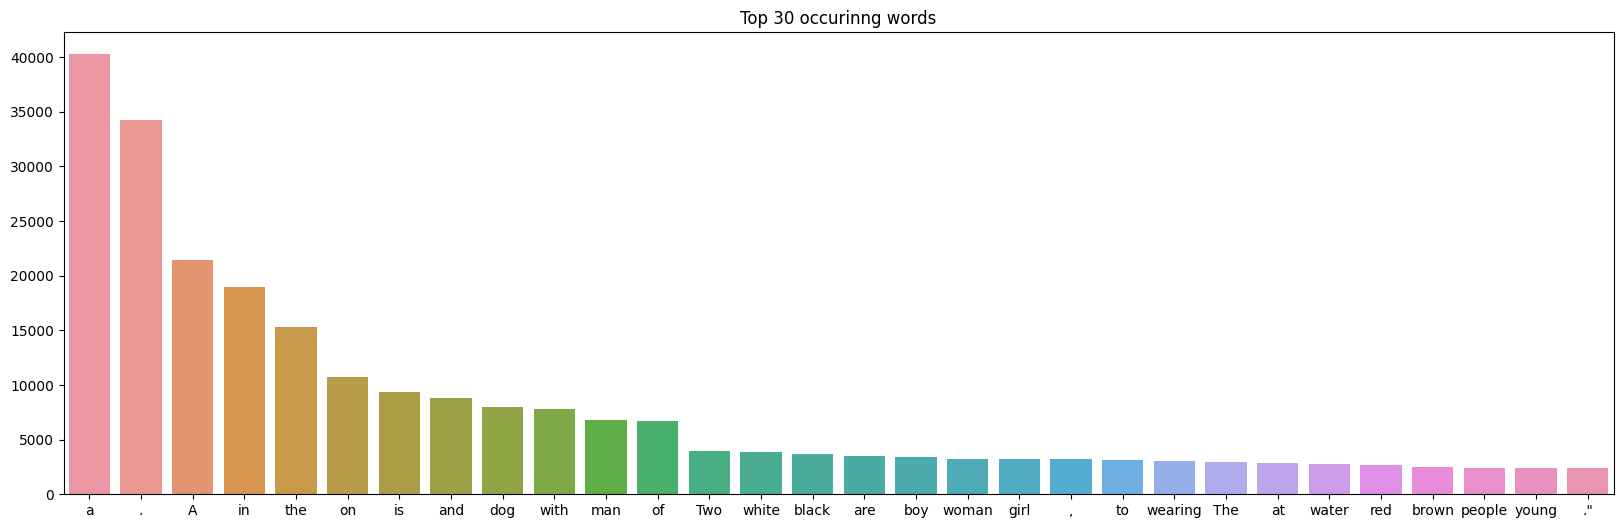

In [32]:
plot_word_count(sorted_list)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [34]:
# create the tokenizer
top_word_count = 5000

filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[:5])
print(annotations[:5])


[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4], [3, 2, 20, 317, 65, 2, 197, 118, 4], [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4], [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4], [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']


In [35]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [36]:
annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [37]:
# printing token
tokenizer.oov_token

'<unk>'

In [38]:
# Create word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Encode training data sentences into sequences
train_seqs  = tokenizer.texts_to_sequences(annotations)

In [39]:
print(train_seqs[1])
print(annotations[1])

[3, 2, 20, 317, 65, 2, 197, 118, 4]
<start> A girl going into a wooden building . <end>


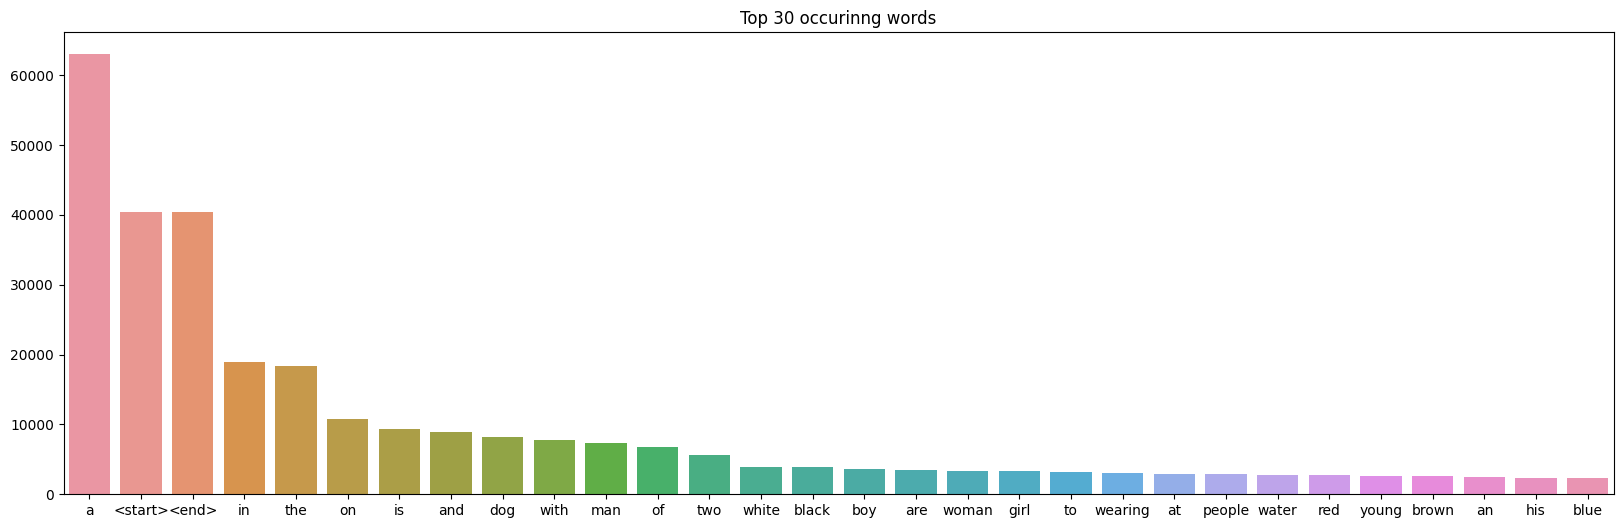

In [40]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)
plot_word_count(sort_word_by_count[:30])

In [41]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

max_length = max([len(t) for t in train_seqs])
print("The maximum length of a sentence in the annotation dataset is: " + str(max_length))

caption_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)
print("The shape of Caption vector is :" + str(caption_vector.shape))



The maximum length of a sentence in the annotation dataset is: 39
The shape of Caption vector is :(40455, 39)


In [42]:
caption_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

In [43]:
print(caption_vector[0])
print(annotations[0])

[  3   2  44   5   2  91 173   8 120  52   2 394  13 395   5  29   1 671
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [45]:
# write your code here for creating the function. This function should return images & their path
# We will use tensorflow to resize
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    
    return image, image_path

Path - ./input/Images/1007129816_e794419615.jpg


2023-02-18 09:32:26.407226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 09:32:37.419627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38224 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)


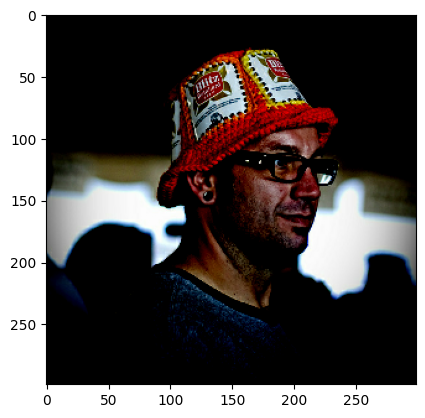

In [46]:
#Load function test 
print("Path -",(all_img_vector[20]))
print("Shape after resize :", load_image(all_img_vector[20])[0].shape)
plt.imshow(load_image(all_img_vector[20])[0])

Here we will call the tensor function to load the image and corresponding path to a tensor. 

In [47]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
#Get unique images
all_img_vector_uniq = sorted(set(all_img_vector))

#Updating Batch Size to 64
BATCH_SIZE = 64
image_dataset = tf.data.Dataset.from_tensor_slices(all_img_vector_uniq).map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

print("Unique number of Images:", len(all_img_vector_uniq))

Unique number of Images: 8091


In [48]:
image_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [49]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [50]:
#Inception V3 Model 
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

# Getting the Pretrained Model Weights
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87910968/87910968 [==============================] - 0s 0us/step


In [51]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [52]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

**Inception Model Image**

In [53]:
keras.utils.plot_model(image_model, "image_model.png", show_shapes=True)

In [54]:
import gc
gc.collect()


88865

In [55]:
# code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_dict = {}
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        #image_dict[path_of_feature] =  bf.numpy()
        path_of_feature1 = os.path.basename(path_of_feature)
        path_of_feature2 = './'+path_of_feature1
        np.save(path_of_feature2, bf.numpy())

  0%|          | 0/127 [00:00<?, ?it/s]2023-02-18 09:35:55.782419: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-02-18 09:36:23.208263: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 127/127 [01:13<00:00,  1.72it/s]


In [56]:
import gc
gc.collect()


23

In [57]:
len(image_dict)

0

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [59]:
# Code for test train split
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,caption_vector,test_size=0.2,random_state=42)

In [60]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  3 558  10 363 139  40   4   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> shepherd dog catches tennis ball <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


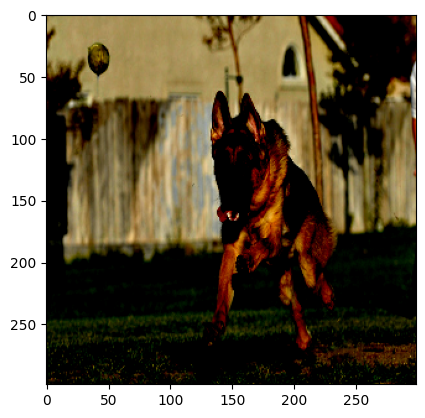

In [62]:
# Lets see the image
print(cap_test[5])
print(" ".join(tokenizer.index_word[i] for i in cap_test[5]))
plt.imshow(load_image(path_test[5])[0])


In [69]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image, caption):
    #Memory utilization
    #img_tensor = image_dict[image.decode('utf-8')]
    img_name_temp = os.path.basename(image.numpy().decode('utf-8'))
    img_name_ip = './'+img_name_temp
    img_tensor = np.load(img_name_ip+'.npy')
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [70]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def data_generator(image,caption, batch_size=32, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((image, caption))
    
    # Use map to load the numpy files in parallel
    #dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [71]:
train_dataset=data_generator(path_train,cap_train,64)
test_dataset=data_generator(path_test,cap_test,64)

In [72]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [73]:
BATCH_SIZE = 32
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

## Encoder


In [75]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) 
        features = tf.nn.relu(features)
        
        return features

In [76]:
encoder=Encoder(embedding_dim)

 ## Attention Model

In [78]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

## Decoder

In [79]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5) #Adding Dropouts
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.dropout(self.embed(x))# embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed, mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [80]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [81]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)


Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [82]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [83]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [84]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [85]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [87]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [88]:
print(tf.__version__)

2.10.1


In [89]:
# Define Test/Validation Step that does not use Teacher Forcing
#Adding this to fetch numpy from TF
#tf.config.run_functions_eagerly(True)

@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            
            #predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            predicted_id = tf.argmax(predictions,1)
            # Not using teacher forcing since test dataset
            #dec_input = tf.expand_dims([predicted_id]* target.shape[0], 1)
            #dec_input = tf.expand_dims(target[:, i], 1)
            dec_input = tf.expand_dims(predicted_id, 1)

        avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [90]:
def test_loss_cal(test_dataset):
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

Before Training the model, let's clear the unused variable and free up some CPU.

In [92]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 11.2 MiB
                caption_vector:  6.0 MiB
                           _42:  6.0 MiB
                     cap_train:  4.8 MiB
                    vocabulary:  3.8 MiB
                      cap_test:  1.2 MiB
                           doc: 352.8 KiB
                    all_img_id: 352.8 KiB
                all_img_vector: 352.8 KiB
                   annotations: 352.8 KiB
                    train_seqs: 334.7 KiB
                  all_img_path: 316.1 KiB
                     val_count: 288.1 KiB
                    word_index: 288.1 KiB
                    index_word: 288.1 KiB
                    path_train: 278.7 KiB
            sort_word_by_count: 74.8 KiB
           all_img_vector_uniq: 71.2 KiB
                     path_test: 67.5 KiB
                      all_imgs: 64.1 KiB


In [93]:
del df 
del caption_vector
gc.collect()

70

In [94]:
import psutil
process = psutil.Process(os.getpid())
process.memory_info()

pmem(rss=7149592576, vms=63728971776, shared=1984020480, text=2396160, lib=0, data=6764388352, dirty=0)

In [95]:
tf.executing_eagerly()

True

In [96]:
#Model Training 

loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            #print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.635, & test loss is 0.946
Time taken for 1 epoch 196.50000047683716 sec

Test loss has been reduced from 100.000 to 0.946


 10%|█         | 2/20 [04:35<38:05, 127.00s/it]  

For epoch: 2, the train loss is 0.494, & test loss is 0.976
Time taken for 1 epoch 77.92986297607422 sec



 15%|█▌        | 3/20 [05:53<29:42, 104.88s/it]

For epoch: 3, the train loss is 0.450, & test loss is 0.933
Time taken for 1 epoch 78.40243196487427 sec

Test loss has been reduced from 0.946 to 0.933


 20%|██        | 4/20 [07:11<25:08, 94.27s/it] 

For epoch: 4, the train loss is 0.419, & test loss is 0.948
Time taken for 1 epoch 77.99248027801514 sec



 25%|██▌       | 5/20 [08:29<22:04, 88.33s/it]

For epoch: 5, the train loss is 0.393, & test loss is 0.984
Time taken for 1 epoch 77.80866146087646 sec



 30%|███       | 6/20 [09:47<19:46, 84.76s/it]

For epoch: 6, the train loss is 0.371, & test loss is 0.961
Time taken for 1 epoch 77.81950902938843 sec



 35%|███▌      | 7/20 [11:04<17:51, 82.42s/it]

For epoch: 7, the train loss is 0.351, & test loss is 1.009
Time taken for 1 epoch 77.59929490089417 sec



 40%|████      | 8/20 [12:22<16:09, 80.82s/it]

For epoch: 8, the train loss is 0.333, & test loss is 1.000
Time taken for 1 epoch 77.39428162574768 sec



 45%|████▌     | 9/20 [13:40<14:39, 79.93s/it]

For epoch: 9, the train loss is 0.315, & test loss is 1.028
Time taken for 1 epoch 77.98283195495605 sec



 50%|█████     | 10/20 [14:57<13:11, 79.11s/it]

For epoch: 10, the train loss is 0.299, & test loss is 1.046
Time taken for 1 epoch 77.25971913337708 sec



 55%|█████▌    | 11/20 [16:15<11:47, 78.65s/it]

For epoch: 11, the train loss is 0.284, & test loss is 1.085
Time taken for 1 epoch 77.60628294944763 sec



 60%|██████    | 12/20 [17:32<10:27, 78.38s/it]

For epoch: 12, the train loss is 0.269, & test loss is 1.133
Time taken for 1 epoch 77.76121950149536 sec



 65%|██████▌   | 13/20 [18:50<09:06, 78.11s/it]

For epoch: 13, the train loss is 0.255, & test loss is 1.153
Time taken for 1 epoch 77.4887843132019 sec



 70%|███████   | 14/20 [20:07<07:47, 77.85s/it]

For epoch: 14, the train loss is 0.243, & test loss is 1.205
Time taken for 1 epoch 77.23819613456726 sec



 75%|███████▌  | 15/20 [21:24<06:27, 77.59s/it]

For epoch: 15, the train loss is 0.231, & test loss is 1.222
Time taken for 1 epoch 77.00463771820068 sec



 80%|████████  | 16/20 [22:41<05:10, 77.52s/it]

For epoch: 16, the train loss is 0.220, & test loss is 1.297
Time taken for 1 epoch 77.34966731071472 sec



 85%|████████▌ | 17/20 [23:59<03:52, 77.58s/it]

For epoch: 17, the train loss is 0.210, & test loss is 1.323
Time taken for 1 epoch 77.70306348800659 sec



 90%|█████████ | 18/20 [25:16<02:34, 77.43s/it]

For epoch: 18, the train loss is 0.201, & test loss is 1.351
Time taken for 1 epoch 77.08271837234497 sec



 95%|█████████▌| 19/20 [26:33<01:17, 77.26s/it]

For epoch: 19, the train loss is 0.192, & test loss is 1.380
Time taken for 1 epoch 76.87154507637024 sec



100%|██████████| 20/20 [27:51<00:00, 83.58s/it]

For epoch: 20, the train loss is 0.185, & test loss is 1.423
Time taken for 1 epoch 78.06487488746643 sec



In [97]:
gc.collect()

695

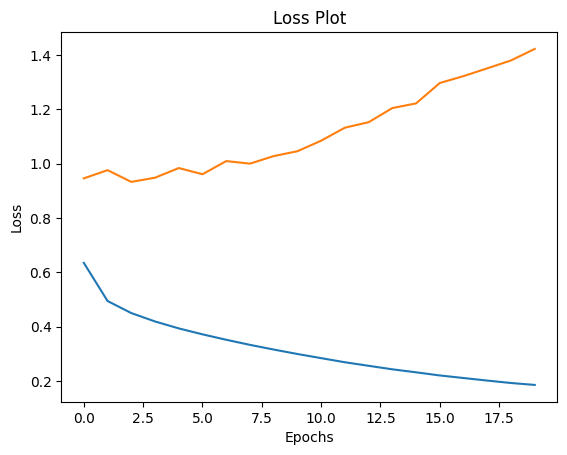

In [98]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function usininit_stateeam search ( optional)

3.Test it on a sample data using BLEU score

## Greedy Search

In [99]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    print("dec_input Shape", dec_input.shape)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        #print("Predicted id", predicted_id)
        #print("result", tokenizer.index_word[predicted_id])

        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

## Beam Search

In [100]:
# Using Beam Search Evaluation
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [101]:
# Plotting different parts of the image which are used for captioning
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [102]:
# Removing start unk and end tag from the caption
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [103]:
from nltk.translate.bleu_score import sentence_bleu
def Testing_Model(img_test):
    #Testing on test image
    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    # test_image = './images/413231421_43833a11f5.jpg'
    # real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption      :', real_caption)
    print ('Prediction Caption:', pred_caption)
    print ('')
    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")
    plot_attmap(result, attention_plot, test_image)
    
    return test_image, pred_caption

In [104]:
from PIL import Image
def Prediction_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    print(test_image)
    #real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    #plot_attmap(result, attention_plot, test_image)
    #plt.imshow(load_image(test_image)[0])
    
    im = Image.open(openImg)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))
    
#    newsize = (200, 200)
    #openImg = openImg.resize(200,200)
    #return Image.open(openImg).resize(newsize)
    return im
    

./input/Images/3485816074_363cab4bff.jpg
dec_input Shape (1, 1)
Prediction Caption: a player in the black football as a man in the black striped flag runs behind him

500 333


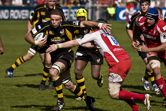

In [105]:
Prediction_Unknown_data(path_test[10])

./input/Images/270263570_3160f360d3.jpg
dec_input Shape (1, 1)
Prediction Caption: two brown dogs run in a rough manner

500 461


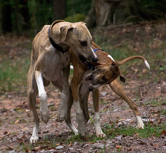

In [106]:
Prediction_Unknown_data(path_test[1])

dec_input Shape (1, 1)
Real Caption      : a person hangs from a safety rope as he climbs down a large cliff
Prediction Caption: a climber climbs a cliff


BELU score: 
Individual 1-gram: 13.223911057726925
Individual 2-gram: 3.678022350221663e-307
Individual 3-gram: 3.678022350221663e-307
Individual 4-gram: 3.678022350221663e-307


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

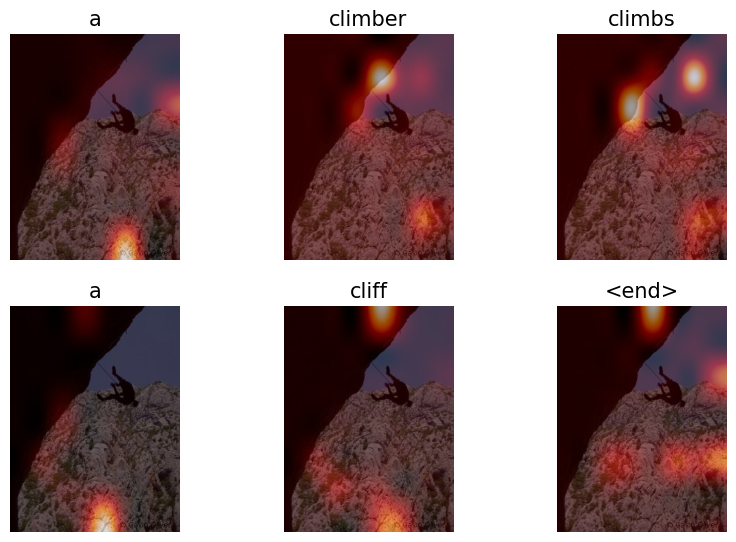

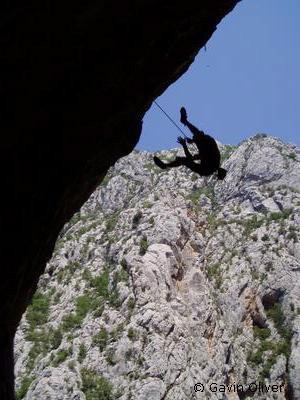

In [107]:
test_image, pred_caption = Testing_Model(path_test)
Image.open(test_image)

dec_input Shape (1, 1)
Real Caption      : a girl wearing a brown jacket and blue jeans has on some white headphones and is walking
Prediction Caption: an old woman in public hall with a bright red sweater and black top and blue top and red top and talks and talks on a sidewalk


BELU score: 
Individual 1-gram: 22.22222222222222
Individual 2-gram: 3.846153846153846
Individual 3-gram: 2.2250738585072627e-306
Individual 4-gram: 2.2250738585072627e-306


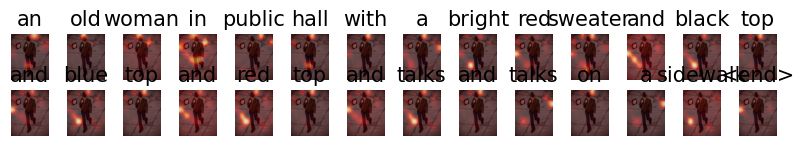

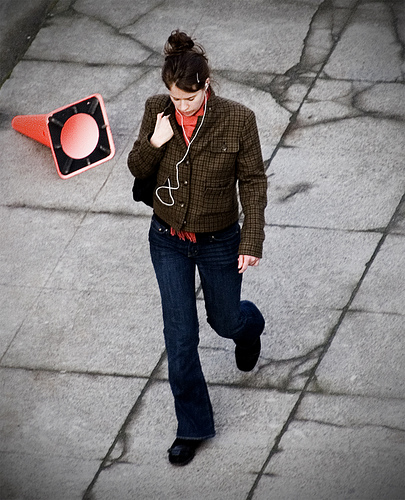

In [108]:
test_image, pred_caption = Testing_Model(path_test)
Image.open(test_image)

In [109]:
beam_caption=beam_evaluate(test_image)
print(beam_caption)

a person wearing her red skateboard


# Converting Text into Audio

In [110]:
pip install gTTS

Note: you may need to restart the kernel to use updated packages.


In [111]:
# Libraries to convert text into audio
from gtts import gTTS
from IPython import display

In [112]:
#Caption to audio conversion
soundFile = 'pred_caption.mp3'

tts = gTTS(pred_caption, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))



## Summary:

The project starts by reading in images and captions, and displaying them. EDA is performed to understand the data. Data cleaning is done which included cleaning the caption file.

Data preprocessing is also performed which included:

Tokenizing the captions and forming an embedding vector.
Preprocessing images.
The data set is split into train and test datasets.

The InceptionV3 model is used. Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.

Here in this project, we are not classifying the images. Rather, we only need to extract a feature vector for our images. Hence we are removing the softmax layer from the model. The shape of the output of this layer is 8x8x2048. Then we squeezed that to a shape of (64, 2048).

This feature vector is given as input to CNN Encoder which had a single fully connected layer. To tell in abstract way, we can say that output from the encoder, hidden state (initialized to 0), and start token is passed as input to the decoder.

The decoder (RNN - here GRU) attends over the image to predict the next word. We used the attention model to make our decoder focus on a particular part of the image at a time rather than focusing on the entire image. This also reduces noise and improves accuracy. The decoder returns the predicted caption and the decoder's hidden state as output. which is sent back to the model and the predictions are used to calculate the loss using cross-entropy "SparseCategoricalCrossentropy". We also used teacher forcing to decide the next input to the decoder.

The decoder stop predicting when the model predicts the end token.

The prediction of the words by the model is done by finding out the probabilities of that word in the vocabulary. We are using the greedy search method. It calculates the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

Finally, we are using the "BLEU score" (Bilingual Evaluation Understudy) as the evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption.